# İbrahim Bartık CS 210: Introduction to Data Science Project

**What is this project?**: This project aims to provide a comprehensive analysis of personal internet usage using data extracted from various Google products, including YouTube, Google Maps, Gmail and general Google account activity. 

For details and comments about the project, please see Project_Report.md file

To see the maps of the project better, please visit: https://ibrahimbartik.github.io/ibartik_cs210/

# 0. Project Index and Information About The Data Source

## Table of Contents

1. Mapping IP Activity in Google Account
2. YouTube Comments Analysis
3. Google Maps Data Analysis and Visualization
4. Gmail Email Data Analysis & Visualization
5. Findings and Future Plans

## 0.1 Import Libraries

In [12]:
import folium
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss
import seaborn as sns
from sklearn.metrics import confusion_matrix
import mailbox
import datetime
from collections import Counter

# 1. Mapping IP Activity in my google account

I have created the script geolocation_df_prep.py to create the dataframe. 
It takes my login IP's, and creates a geolocation dataframe. The script makes use of https://geolocation-db.com/ which does not require an API key to use. 

This dataset includes all the places I have logged into my google account.

In [13]:
geolocation_df=pd.read_csv("geolocation.csv")
geolocation_df=geolocation_df.drop(columns="Unnamed: 0")
geolocation_df.drop_duplicates(inplace=True)
geolocation_df = geolocation_df.dropna()
geolocation_df["latitude"]= pd.to_numeric(geolocation_df["latitude"], errors='coerce')
geolocation_df["longitude"]= pd.to_numeric(geolocation_df["longitude"], errors='coerce')
geolocation_df = geolocation_df.dropna()
geolocation_df.reset_index(inplace=True)
geolocation_df=geolocation_df.drop(columns="index")
geolocation_df.head()

,latitude,longitude
0,41.0041,28.9640
1,41.0605,28.9872
2,41.0214,28.9948
3,40.2500,28.9833
4,36.8524,30.6183


In [14]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   61 non-null     float64
 1   longitude  61 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


In [15]:
map_center = [41.01384, 28.94966]  
all_map = folium.Map(location=map_center, zoom_start=5)

for i in range(len(geolocation_df)):
    lat=geolocation_df.loc[i]["latitude"]
    long=geolocation_df.loc[i]["longitude"]
    location=[lat,long]
    folium.Marker(location=location).add_to(all_map)

all_map.save('all_map.html')
all_map

In [16]:
map_center = [39.9334, 32.8597]  
tr_map = folium.Map(location=map_center, zoom_start=7)

for i in range(len(geolocation_df)):
    lat=geolocation_df.loc[i]["latitude"]
    long=geolocation_df.loc[i]["longitude"]
    location=[lat,long]
    folium.Marker(location=location).add_to(tr_map)

tr_map.save('tr_map.html')
tr_map

# 2. Youtube Comments Analysis

This project initially had a plan of including sentimental analysis of youtube comments using the BERT-Turkish pre-trained model. Unfortunately, for one reason or another, this caused a lot of problems, and I came to conclusion it was best to leave the sentimental analysis for now with the plan of adding it back in the future.

For that reason, I manually labeled my youtube comments data, which was small enough for me to handle.

**Sentiment Mappings**: 1 = Neutral, 2 = Positive ,3 = Negative

In [17]:
def extract_comments(json_str):
    try:
        data = json.loads(json_str)
        return data.get('text')
    except json.JSONDecodeError:
        return 

In [18]:
yt_comments_df = pd.read_csv("youtube_yorumlar.csv")

yt_comments_df["Zaman"]=pd.to_datetime(yt_comments_df["Yorumun Oluşturulma Zaman Damgası"])
yt_comments_df=yt_comments_df.drop(columns=["Yorumun Oluşturulma Zaman Damgası","Yorum Kimliği","Fiyat","Ana Yorum Kimliği","Kanal Kimliği"])
yt_comments_df["Yorum Metni"]=yt_comments_df["Yorum Metni"].apply(extract_comments)
yt_comments_df=yt_comments_df.dropna()

# To hide the videos I commented from, I will only leave the first 5 chars of Youtube Video ID
# This way, they are still distinct enough to work with, without end user being able to know where they belong
yt_comments_df['Video Kimliği'] = yt_comments_df['Video Kimliği'].apply(lambda x: x[:5]) 

yt_comments_df=yt_comments_df.reset_index(drop=True)
yt_comments_df.head(3)

,Video Kimliği,Yorum Metni,Sentiment,Zaman
0,ePl8r,Facia bir yorum,3,2023-03-26 10:21:07.730730+00:00
1,PPf7-,Ben ibrahim bartık bizden biri okursa selam ça...,1,2022-08-25 22:09:37.312466+00:00
2,PPf7-,Çok iyi,2,2022-08-25 22:09:19.149027+00:00


In [19]:
#Naive Bayes Model
X = yt_comments_df['Yorum Metni']
y = yt_comments_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Vectorize the comment data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

modelMNB = MultinomialNB()

modelMNB.fit(X_train_vectorized, y_train)

y_predMNB = modelMNB.predict(X_test_vectorized)


def print_f1s(y_test,y_pred):
    f1_scores = f1_score(y_test, y_pred, average=None)
    # F1-score for each class
    for i, f1 in enumerate(f1_scores):
        print(f"F1-score for Class {i+1}: {f1}")

def print_confmat(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\n Confusion Matrix:")
    print(conf_matrix,"\n")

print_f1s(y_pred=y_predMNB,y_test=y_test)
print_confmat(y_pred=y_predMNB,y_test=y_test)
accuracy_score(y_test, y_predMNB)

F1-score for Class 1: 0.0
F1-score for Class 2: 0.0
F1-score for Class 3: 0.0

 Confusion Matrix:
[[0 0 2]
 [2 0 1]
 [1 0 0]] 



0.0

In [20]:
#Random Forest Classifie
X = yt_comments_df['Yorum Metni']
y = yt_comments_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

modelRF = RandomForestClassifier(n_estimators=10)


modelRF.fit(X_train_vectorized, y_train)
y_predRF = modelRF.predict(X_test_vectorized)

print_f1s(y_pred=y_predRF,y_test=y_test)
print_confmat(y_pred=y_predRF,y_test=y_test)
accuracy_score(y_test, y_predRF)

F1-score for Class 1: 0.6666666666666666
F1-score for Class 2: 0.0
F1-score for Class 3: 0.0

 Confusion Matrix:
[[3 0 0]
 [1 0 0]
 [2 0 0]] 



0.5

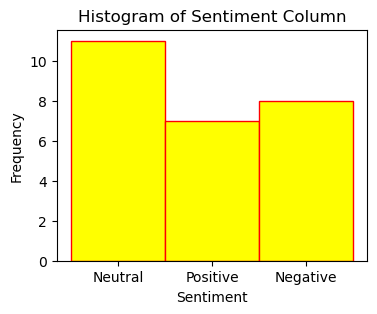

In [21]:
#Our models are not picking up on "Positive" and "Negative" comments. It may be a data imbalance.
#Here is a histogram to see if that is the case
plt.figure(figsize=(4, 3))
plt.hist(yt_comments_df['Sentiment'], bins=[1, 2,3,4], color="yellow", edgecolor='red')

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Column')

sentiment_labels = ['Neutral', 'Positive','Negative']
plt.xticks([1.5,2.5,3.5], sentiment_labels)
plt.show()

In [22]:
#Everything from the F1 scores to confusion matrix, also the histogram points out to a data imbalance
#This effect is likely magnified because the data set is smaller than the ones we usually have.

#To solve this problem, I am going to try to Undersample Neutral data randomly
#To achieve this, I will be using imbalanced-learn library's NearMiss function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Apply NearMiss for undersampling
near_miss = NearMiss() 
X_resampled, y_resampled = near_miss.fit_resample(X_train_vectorized, y_train)

In [23]:
#Refitting Random Forest
modelRF.fit(X_resampled, y_resampled)
y_predRF = modelRF.predict(X_test_vectorized)

print_f1s(y_pred=y_predRF,y_test=y_test)
print_confmat(y_pred=y_predRF,y_test=y_test)
accuracy_score(y_test, y_predRF)

F1-score for Class 1: 0.0
F1-score for Class 2: 0.2857142857142857
F1-score for Class 3: 0.0

 Confusion Matrix:
[[0 3 0]
 [0 1 0]
 [0 2 0]] 



0.16666666666666666

In [24]:
# Refitting Naive Bayes
modelMNB.fit(X_resampled, y_resampled)
y_predMNB = modelMNB.predict(X_test_vectorized)
print_f1s(y_pred=y_predMNB,y_test=y_test)
print_confmat(y_pred=y_predMNB,y_test=y_test)
accuracy_score(y_test, y_predMNB)

F1-score for Class 1: 0.7499999999999999
F1-score for Class 2: 0.0
F1-score for Class 3: 0.0

 Confusion Matrix:
[[3 0 0]
 [1 0 0]
 [1 1 0]] 



0.5

In [25]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(modelRF, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found by grid search
print("Best Parameters:")
print(grid_search.best_params_)

# Use the best model for predictions
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test_vectorized)

print_f1s(y_pred=y_pred_tuned,y_test=y_test)
print_confmat(y_pred=y_pred_tuned,y_test=y_test)
accuracy_score(y_test, y_pred_tuned)

Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
F1-score for Class 1: 0.0
F1-score for Class 2: 0.0
F1-score for Class 3: 0.5

 Confusion Matrix:
[[0 0 3]
 [0 0 1]
 [0 0 2]] 



0.3333333333333333

# 3. Google Maps Data Analysis and Visualization

In [26]:
maps_rota_df = pd.read_json("maps_rotalar.json")
maps_rota_df["place_visit"].to_json("place_visit.json")

In [27]:
maps_rota_df

,id,place_visit,transition
0,3ADFCF37167402A4,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."
1,407265A28ECAA941,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."
2,4255AFE8CC81DD08,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."
3,45B7DC7C36B7B267,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."
4,47F6C4B3EBFFAA0B,"[{'id': 'SOURCE_ID', 'place': {'lat_lng': {'la...","[{'route': {'travel_mode': 'TRANSIT', 'transit..."
5,4883D7511BFD4467,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."
6,4891293CD1AD5344,"[{'id': ''}, {'id': 'DESTINATION_ID', 'place':...","[{'route': {'travel_mode': 'DRIVE'}, 'origin':..."


In [28]:
json_file_path = 'place_visit.json'

with open(json_file_path, 'r',encoding="utf-8-sig") as file:
    data_dict = json.load(file)

place_df = pd.DataFrame.from_dict(data_dict, orient='index')

coordinates = []

def extract_coordinates(row):
    for item in row:
        if 'id' in item and item['id'] != '' and 'place' in item and 'lat_lng' in item['place']:
            latitude = item['place']['lat_lng']['latitude']
            longitude = item['place']['lat_lng']['longitude']
            coordinates.append((latitude, longitude))

place_df.apply(extract_coordinates, axis=1)

0    None
1    None
2    None
3    None
4    None
5    None
6    None
dtype: object

In [29]:
# This map shows all the places I visited using Google Maps
map_center = [41.01384, 28.94966]  
visit_map = folium.Map(location=map_center, zoom_start=4)

for i in range(len(coordinates)):
    folium.Marker(location=coordinates[i]).add_to(visit_map)

visit_map.save('visit_map.html')
visit_map

# 4. Gmail Email Data Analysis & Visualization

In [30]:
def analyze_mbox(mbox_file):
    mbox = mailbox.mbox(mbox_file)

    sender_list = []

    for message in mbox:
        sender = message['From']
        sender_list.append(sender)

    return sender_list

mbox_file_path = 'Gmail.mbox'

In [31]:
senders = analyze_mbox(mbox_file_path)
sender_counts = Counter(senders)

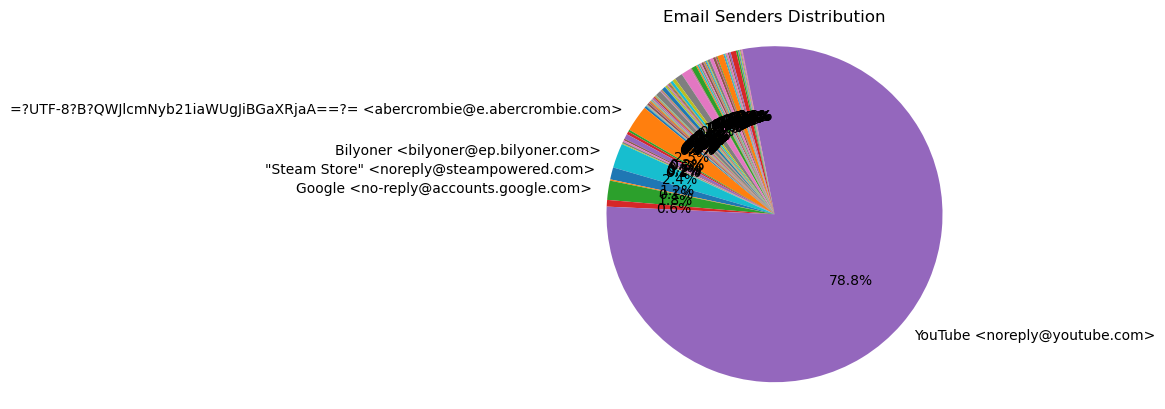

In [32]:
# Create a pie chart
label_threshold = 0.01  # Adjust the threshold as needed

# Create a pie chart
labels = [label if count/sum(sender_counts.values()) > label_threshold else '' for label, count in sender_counts.items()]
sizes = sender_counts.values()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Email Senders Distribution')

# Show the chart
plt.show()
plt.show()

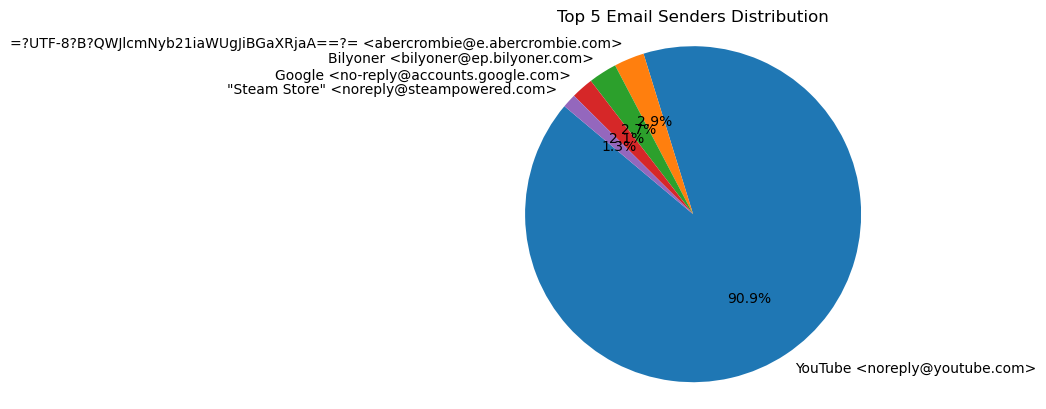

In [33]:
# Select the top N most frequent senders
top_n = 5  # Adjust the value to show the desired number of senders
top_senders = dict(sender_counts.most_common(top_n))

# Create a pie chart
labels = top_senders.keys()
sizes = top_senders.values()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Top {top_n} Email Senders Distribution')

# Show the chart
plt.show()

In [34]:
def plot_exclude_top_n(n,label_thres):
    exclude_top_n = n
    
    excluded_senders = dict(sender_counts.most_common()[exclude_top_n:])
    total_excluded = sum(excluded_senders.values())
    label_threshold = label_thres 
    
    labels = [label if count/sum(excluded_senders.values()) > label_threshold else '' for label, count in excluded_senders.items()]
    sizes = excluded_senders.values()
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Email Senders Distribution (Excluding Top {exclude_top_n})')
    
    # Show the chart
    plt.show()

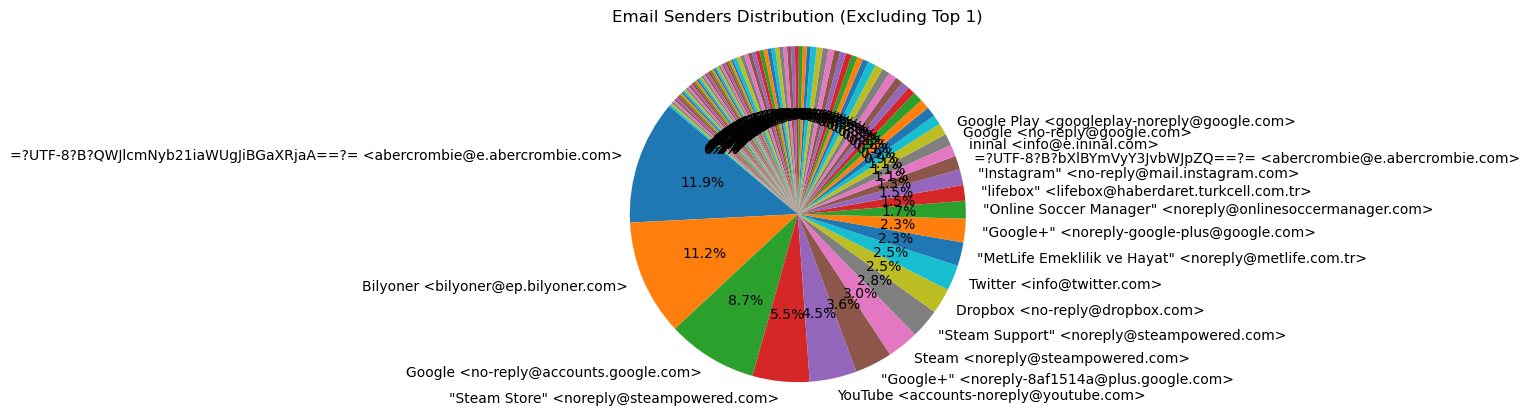

In [35]:
plot_exclude_top_n(1,0.01)

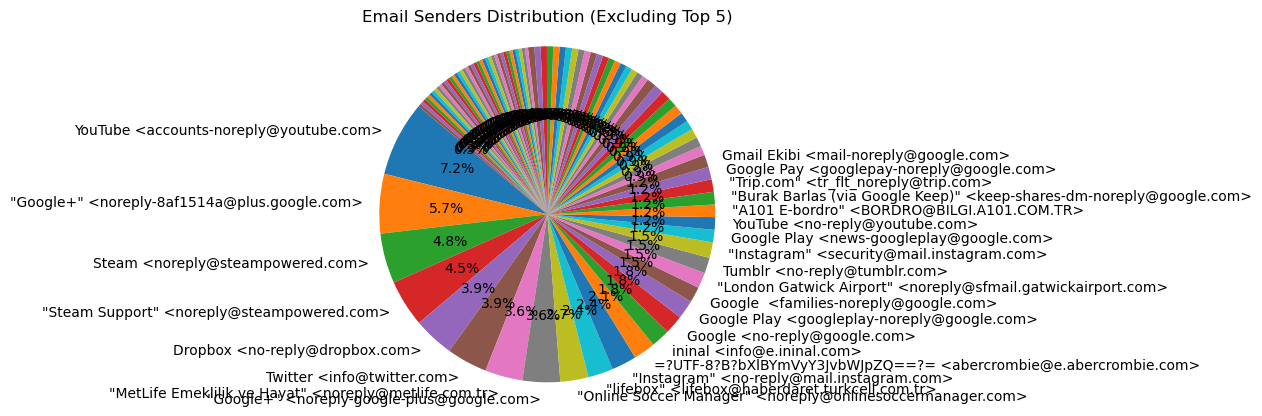

In [36]:
plot_exclude_top_n(5,0.01)

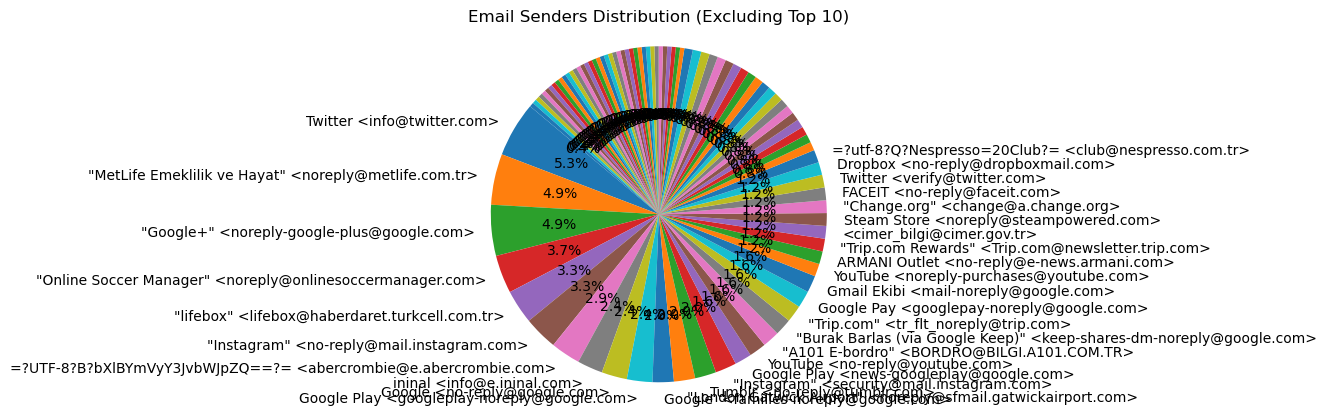

In [37]:
plot_exclude_top_n(10,0.01)

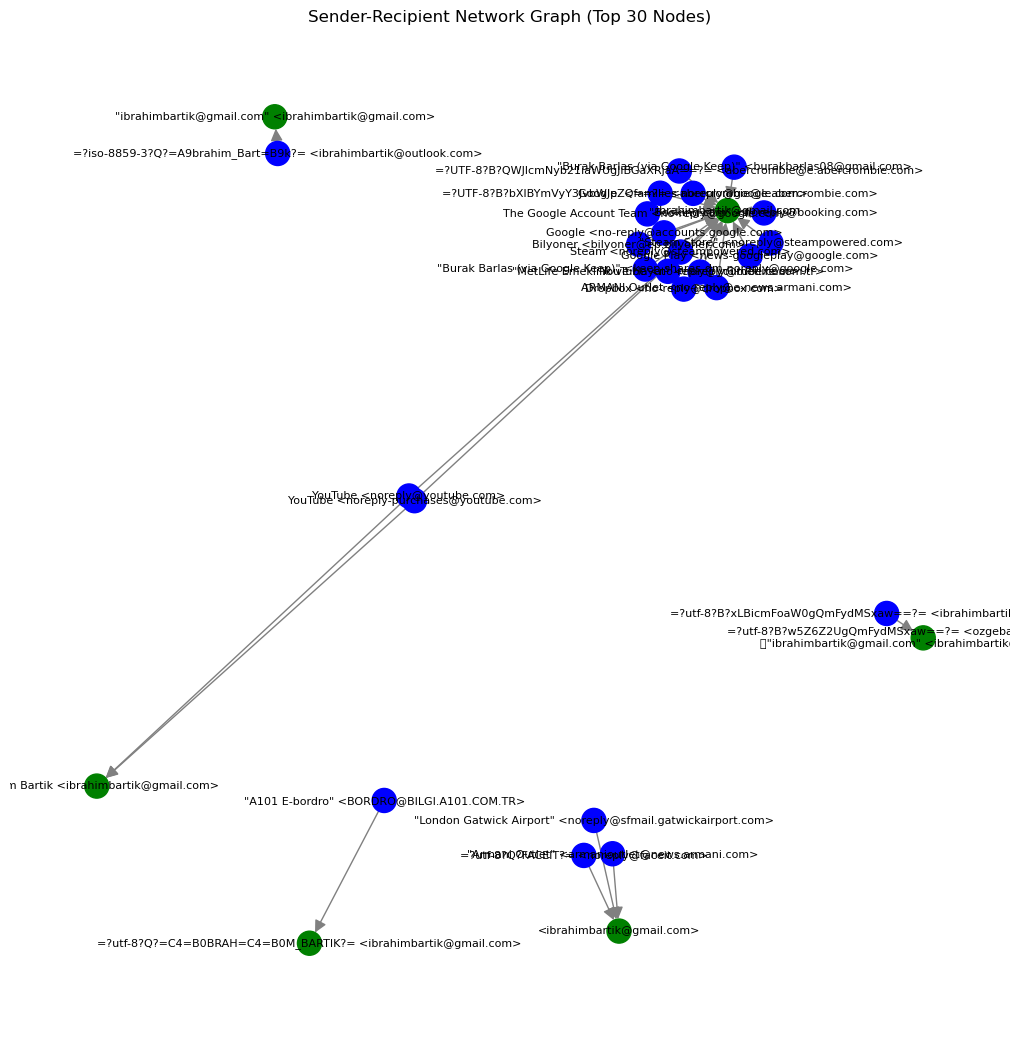

In [60]:
#Analysis/Visualization of GMail Sender-Reciever Graph with python networkx library

def analyze_sender_recipient_network(mbox_file):
    mbox = mailbox.mbox(mbox_file)

    G = nx.DiGraph()

    for message in mbox:
        sender = message['from']
        recipients = message['to'].split(', ') if message['to'] else []

        G.add_node(sender, color='blue')

        for recipient in recipients:
            G.add_node(recipient, color='green')

            G.add_edge(sender, recipient)

    return G

mbox_file_path = 'Gmail.mbox'
email_network = analyze_sender_recipient_network(mbox_file_path)

# Extract top 30 nodes for visualization
top_nodes = list(email_network.nodes())[:30]
email_network_subset = email_network.subgraph(top_nodes)

pos = nx.spring_layout(email_network_subset)
node_colors = [email_network_subset.nodes[node]['color'] for node in email_network_subset.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(email_network_subset, pos, with_labels=True, node_color=node_colors, edge_color='gray', arrowsize=18, font_size=8)
plt.title('Sender-Recipient Network Graph (Top 30 Nodes)')

plt.show()

# 5. Findings and What Could Be Done Better & Future Plans

Please see the "Project_Report.md" file in the repositort for findings, detailed comments and future plans